In [1]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
data = pd.read_csv("10.csv")

# Separate data into different dataframes based on data types
spo2_data = data[data['data_type'] == 'spo2'].copy()
heart_rate_data = data[data['data_type'] == 'hr'].copy()
steps_data = data[data['data_type'] == 'steps'].copy()
hrv_data = data[data['data_type'] == 'hrv'].copy()
br_data = data[data['data_type'] == 'br'].copy()
sleep_data = data[data['data_type'] == 'sleep'].copy()

# Convert timestamps to datetime format for each dataframe
spo2_data['time'] = pd.to_datetime(spo2_data['time'])
heart_rate_data['time'] = pd.to_datetime(heart_rate_data['time'])
steps_data['time'] = pd.to_datetime(steps_data['time'])
hrv_data['time'] = pd.to_datetime(hrv_data['time'])
br_data['time'] = pd.to_datetime(br_data['time'])
sleep_data['time'] = pd.to_datetime(sleep_data['time'])

# Sort dataframes based on time and their respective formats
spo2_data.sort_values(by='time', inplace=True)
heart_rate_data.sort_values(by='time', inplace=True)
steps_data.sort_values(by='time', inplace=True)
hrv_data.sort_values(by='time', inplace=True)
br_data.sort_values(by='time', inplace=True)
sleep_data.sort_values(by='time', inplace=True)

In [5]:
heart_rate_data=heart_rate_data[['value', 'time']]

In [6]:
heart_rate_data

,value,time
2,70,2023-11-23 00:00:00+00:00
3,75,2023-11-23 00:01:00+00:00
4,78,2023-11-23 00:02:00+00:00
5,74,2023-11-23 00:03:00+00:00
6,76,2023-11-23 00:04:00+00:00
...,...,...
53937,62,2023-12-20 23:55:00+00:00
53938,63,2023-12-20 23:56:00+00:00
53939,63,2023-12-20 23:57:00+00:00
53940,62,2023-12-20 23:58:00+00:00


In [7]:
steps_data=steps_data[['value', 'time']]

In [8]:
steps_data

,value,time
39,16,2023-11-23 00:36:00+00:00
73,7,2023-11-23 01:10:00+00:00
76,4,2023-11-23 01:12:00+00:00
78,11,2023-11-23 01:13:00+00:00
525,35,2023-11-23 06:09:00+00:00
...,...,...
53887,25,2023-12-20 23:15:00+00:00
53890,23,2023-12-20 23:16:00+00:00
53891,5,2023-12-20 23:17:00+00:00
53896,4,2023-12-20 23:20:00+00:00


In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load craving and non-craving data
craving_data = pd.read_csv('ID10_Crave.csv')
non_craving_data = pd.read_csv('ID10_None.csv')

# Filter rows with 'Carrot' in the substance_fruit_label column
craving_data = craving_data[craving_data['substance_fruit_label'] == 'Nectarine']

# Convert timestamps to ensure they are timezone-naive
craving_data['hawaii_createdat_time'] = pd.to_datetime(craving_data['hawaii_createdat_time']).dt.tz_localize(None)
non_craving_data['hawaii_createdat_time'] = pd.to_datetime(non_craving_data['hawaii_createdat_time']).dt.tz_localize(None)

# Ensure heart rate and steps data use the same timezone-naive datetime index
heart_rate_data['time'] = pd.to_datetime(heart_rate_data['time']).dt.tz_localize(None)
steps_data['time'] = pd.to_datetime(steps_data['time']).dt.tz_localize(None)

heart_rate_data.set_index('time', inplace=True)
steps_data.set_index('time', inplace=True)

# Convert the 'value' column to numeric, coercing errors
heart_rate_data['value'] = pd.to_numeric(heart_rate_data['value'], errors='coerce')
steps_data['value'] = pd.to_numeric(steps_data['value'], errors='coerce')

# Remove duplicate timestamps
heart_rate_data = heart_rate_data[~heart_rate_data.index.duplicated(keep='first')]
steps_data = steps_data[~steps_data.index.duplicated(keep='first')]

# Reindex and forward fill to handle missing data
heart_rate_data = heart_rate_data.reindex(pd.date_range(start=heart_rate_data.index.min(), end=heart_rate_data.index.max(), freq='min'), method='ffill')
steps_data = steps_data.reindex(pd.date_range(start=steps_data.index.min(), end=steps_data.index.max(), freq='min'), method='ffill').fillna(0)

# Initialize the StandardScaler
scaler = StandardScaler()

def process_label_data(label_data, heart_rate_data, steps_data, scaler):
    results = []
    for _, row in label_data.iterrows():
        timestamp = row['hawaii_createdat_time']
        lower_bound = timestamp - pd.Timedelta(hours=1)
        upper_bound = timestamp + pd.Timedelta(hours=1)

        # Extract data within the window
        hr_window = heart_rate_data.loc[lower_bound:upper_bound]
        steps_window = steps_data.loc[lower_bound:upper_bound]

        # Resample and calculate mean every 4 minutes to get 30 points
        hr_means = hr_window.resample('4min').mean().iloc[:30]  # Ensure 30 data points
        steps_means = steps_window.resample('4min').mean().iloc[:30]

        if len(hr_means) == 30 and len(steps_means) == 30:
            # Standardize the means
            hr_scaled = scaler.fit_transform(hr_means.values.reshape(-1, 1))
            steps_scaled = scaler.fit_transform(steps_means.values.reshape(-1, 1))

            results.append({
                'timestamp': timestamp,
                'heart_rate_means': hr_scaled.flatten().tolist(),
                'steps_means': steps_scaled.flatten().tolist()
            })

    return pd.DataFrame(results)

# Process craving and non-craving labels
craving_features = process_label_data(craving_data, heart_rate_data, steps_data, scaler)
non_craving_features = process_label_data(non_craving_data, heart_rate_data, steps_data, scaler)

# Output results
print("Craving Features Data:")
print(craving_features.head())
print("Non-Craving Features Data:")
print(non_craving_features.head())


Craving Features Data:
            timestamp                                   heart_rate_means  \
0 2023-11-27 17:06:54  [-0.4077798470617748, -0.04921480912814488, 0....   
1 2023-11-28 15:09:42  [1.1164115773804473, 0.2702891187342125, 1.045...   
2 2023-12-01 22:15:58  [0.7188871800370492, 0.26071932629568195, 1.20...   
3 2023-12-03 16:03:29  [-0.5342255889956353, -0.7594260714762308, -0....   
4 2023-12-03 18:00:44  [-0.1947903537684357, -0.0837459715726514, -0....   

                                         steps_means  
0  [1.0239999054945357, 0.44762568968255284, -0.5...  
1  [1.1358660206519509, 1.1358660206519509, 1.135...  
2  [0.657301726469514, 0.4913630016946017, 1.5976...  
3  [-0.467168836263489, -0.467168836263489, -0.46...  
4  [-0.2777670839733358, -0.3793891878660196, -0....  
Non-Craving Features Data:
            timestamp                                   heart_rate_means  \
0 2023-11-28 15:09:42  [1.1164115773804473, 0.2702891187342125, 1.045...   
1 2023-11-2

In [10]:
# Print the shape of the craving features data
print("Shape of Craving Features Data:", craving_features.shape)

# Print the shape of the non-craving features data
print("Shape of Non-Craving Features Data:", non_craving_features.shape)

Shape of Craving Features Data: (25, 3)
Shape of Non-Craving Features Data: (61, 3)


In [11]:
import pandas as pd

# Adding label columns
craving_features['state'] = 'crave'
craving_features['state_val'] = 1

non_craving_features['state'] = 'non_crave'
non_craving_features['state_val'] = 0

# Combining the dataframes
combined_data = pd.concat([craving_features, non_craving_features])

# Converting timestamps to datetime and sorting
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'])
combined_data_sorted = combined_data.sort_values(by='timestamp').reset_index(drop=True)

# This combined_data_sorted is now ready for use in your neural network model
print(combined_data_sorted)


             timestamp                                   heart_rate_means  \
0  2023-11-27 17:06:54  [-0.4077798470617748, -0.04921480912814488, 0....   
1  2023-11-28 15:09:42  [1.1164115773804473, 0.2702891187342125, 1.045...   
2  2023-11-28 15:09:42  [1.1164115773804473, 0.2702891187342125, 1.045...   
3  2023-11-29 09:30:29  [-1.6865439786173657, -1.4703203916151393, -1....   
4  2023-11-29 09:30:29  [-1.6865439786173657, -1.4703203916151393, -1....   
..                 ...                                                ...   
81 2023-12-19 21:04:47  [2.7477021384420746, 3.377959771807056, 2.4823...   
82 2023-12-19 21:04:47  [2.7477021384420746, 3.377959771807056, 2.4823...   
83 2023-12-20 15:47:33  [-0.5898899676932021, -0.5898899676932021, -0....   
84 2023-12-20 18:42:51  [0.06869206174208, 0.5838825248076779, 0.47348...   
85 2023-12-20 18:42:51  [0.06869206174208, 0.5838825248076779, 0.47348...   

                                          steps_means      state  state_val

In [12]:
import tensorflow as tf

# Load pretrained models
encoder_hr = tf.keras.models.load_model('heart_rate_encoder')
encoder_steps = tf.keras.models.load_model('steps_encoder')

In [13]:
import numpy as np

# Function to generate embeddings using the loaded models
def generate_embeddings(hr_data, steps_data, encoder_hr, encoder_steps):
    # Convert lists to numpy arrays and ensure they are in the correct shape
    hr_data = np.array(hr_data.tolist())
    steps_data = np.array(steps_data.tolist())

    # Reshape data if required by the model, assuming the model expects shape (samples, features)
    if hr_data.ndim == 1:
        hr_data = hr_data.reshape(-1, 1)
    if steps_data.ndim == 1:
        steps_data = steps_data.reshape(-1, 1)

    # Generate embeddings
    hr_embeddings = encoder_hr.predict(hr_data)
    steps_embeddings = encoder_steps.predict(steps_data)

    return hr_embeddings, steps_embeddings

# Use the function with your data
hr_embeddings, steps_embeddings = generate_embeddings(
    combined_data_sorted['heart_rate_means'],
    combined_data_sorted['steps_means'],
    encoder_hr,
    encoder_steps
)


3/3 [==============================] - 0s 3ms/step


Epoch 1/50


4/4 [==============================] - 3s 170ms/step - loss: 2.4467 - accuracy: 0.2787 - precision: 0.2041 - recall: 0.6667 - val_loss: 2.2911 - val_accuracy: 0.5714 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 2/50
4/4 [==============================] - 0s 21ms/step - loss: 2.4554 - accuracy: 0.2951 - precision: 0.2083 - recall: 0.6667 - val_loss: 2.2313 - val_accuracy: 0.5714 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 3/50
4/4 [==============================] - 0s 40ms/step - loss: 2.2222 - accuracy: 0.4098 - precision: 0.2558 - recall: 0.7333 - val_loss: 2.1740 - val_accuracy: 0.8571 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 4/50
4/4 [==============================] - 0s 25ms/step - loss: 2.1570 - accuracy: 0.4590 - precision: 0.2750 - recall: 0.7333 - val_loss: 2.1191 - val_accuracy: 0.5714 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 5/50
4/4 [==============================] - 0s 21ms/step - loss: 2.1274 - accuracy: 0.4262 - precision: 0.2

Epoch 35/50
4/4 [==============================] - 0s 20ms/step - loss: 1.2685 - accuracy: 0.6721 - precision: 0.3913 - recall: 0.6000 - val_loss: 1.3689 - val_accuracy: 0.4286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 36/50
4/4 [==============================] - 0s 18ms/step - loss: 1.2602 - accuracy: 0.6557 - precision: 0.3929 - recall: 0.7333 - val_loss: 1.3596 - val_accuracy: 0.4286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 37/50
4/4 [==============================] - 0s 26ms/step - loss: 1.2599 - accuracy: 0.6885 - precision: 0.4167 - recall: 0.6667 - val_loss: 1.3508 - val_accuracy: 0.4286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 38/50
4/4 [==============================] - 0s 20ms/step - loss: 1.1997 - accuracy: 0.7049 - precision: 0.4444 - recall: 0.8000 - val_loss: 1.3422 - val_accuracy: 0.4286 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 39/50
4/4 [==============================] - 0s 18ms/step - loss: 1.2577 -

Threshold: 0.68, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.69, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.70, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.71, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.72, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.73, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.74, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.75, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.76, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.77, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.78, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.79, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.80, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.81, Sensitivity: 0.00, Specificity: 1.00, Accuracy: 0.72
Threshold: 0.82, Sen

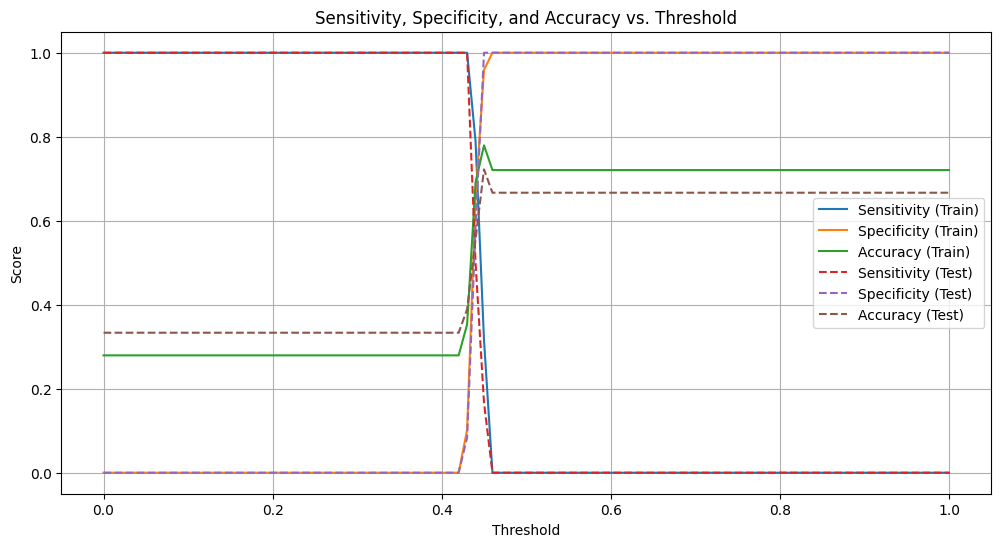

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.metrics import recall_score, precision_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Combine the heart rate and steps embeddings
combined_embeddings = np.concatenate([hr_embeddings, steps_embeddings], axis=1)

# Labels from your existing DataFrame
labels = combined_data_sorted['state_val'].values

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, labels, test_size=0.2, random_state=42)

# Define the model with regularization and batch normalization
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate thresholds on training set
probabilities_train = model.predict(X_train)
thresholds = np.arange(0, 1.01, 0.01)

# Store training results
training_results = []

print("\nTraining Set Evaluation:")
for threshold in thresholds:
    predicted_classes = (probabilities_train > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_train, predicted_classes).ravel()
    recall = tp / (tp + fn)  # Sensitivity
    specificity = tn / (tn + fp)  # Specificity
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    training_results.append((threshold, recall, specificity, accuracy))
    print(f"Threshold: {threshold:.2f}, Sensitivity: {recall:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2f}")

# Convert training results to DataFrame for easy viewing
training_results_df = pd.DataFrame(training_results, columns=['Threshold', 'Sensitivity', 'Specificity', 'Accuracy'])

# Select best threshold based on a specific criterion
# Here, we select the threshold with the highest sensitivity while keeping specificity above 0.5
best_threshold_row = training_results_df[(training_results_df['Sensitivity'] > 0.9) & (training_results_df['Specificity'] > 0.5)]
if not best_threshold_row.empty:
    best_threshold = best_threshold_row.iloc[0]['Threshold']
else:
    best_threshold = 0.5  # Default threshold if criteria is not met

print(f"\nBest Threshold from Training Set: {best_threshold}")

# Evaluate the best threshold on the test set
probabilities_test = model.predict(X_test)
predicted_classes_test = (probabilities_test > best_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, predicted_classes_test).ravel()
recall_test = tp / (tp + fn)  # Sensitivity
specificity_test = tn / (tn + fp)  # Specificity
accuracy_test = (tp + tn) / (tp + tn + fp + fn)

print(f"\nTest Set Evaluation at Best Threshold ({best_threshold}):")
print(f"Sensitivity: {recall_test:.2f}")
print(f"Specificity: {specificity_test:.2f}")
print(f"Accuracy: {accuracy_test:.2f}")

# Evaluate thresholds on test set
print("\nTest Set Evaluation for Each Threshold:")
test_results = []

for threshold in thresholds:
    predicted_classes = (probabilities_test > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, predicted_classes).ravel()
    recall = tp / (tp + fn)  # Sensitivity
    specificity = tn / (tn + fp)  # Specificity
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    test_results.append((threshold, recall, specificity, accuracy))
    print(f"Threshold: {threshold:.2f}, Sensitivity: {recall:.2f}, Specificity: {specificity:.2f}, Accuracy: {accuracy:.2f}")

# Convert test results to DataFrame for easy viewing
test_results_df = pd.DataFrame(test_results, columns=['Threshold', 'Sensitivity', 'Specificity', 'Accuracy'])

# Plot the training results
plt.figure(figsize=(12, 6))
plt.plot(training_results_df['Threshold'], training_results_df['Sensitivity'], label='Sensitivity (Train)')
plt.plot(training_results_df['Threshold'], training_results_df['Specificity'], label='Specificity (Train)')
plt.plot(training_results_df['Threshold'], training_results_df['Accuracy'], label='Accuracy (Train)')
plt.plot(test_results_df['Threshold'], test_results_df['Sensitivity'], label='Sensitivity (Test)', linestyle='dashed')
plt.plot(test_results_df['Threshold'], test_results_df['Specificity'], label='Specificity (Test)', linestyle='dashed')
plt.plot(test_results_df['Threshold'], test_results_df['Accuracy'], label='Accuracy (Test)', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Sensitivity, Specificity, and Accuracy vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Training: Threshold: 0.51, Sensitivity: 0.71, Specificity: 0.81, Accuracy: 0.78
Test: Threshold: 0.51, Sensitivity: 0.33, Specificity: 0.79, Accuracy: 0.71